# Measure the Homogeneity and Specificity of the Endoderm cluster
- we will use the umap coordinates as a measure

In [56]:
%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
#import scrublet as scr
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [59]:
#Introduce variables

#name of first object (arbitrary)
data1 = "YS_endoderm"
Object1 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V9_scvi_YS_integrated/A2_V9_scvi_V8_model_selected_raw_qc_scr_umap.h5ad"

#Procide neighbour intervals to study
inte = [5,10,15,20,25,30,35,40,45,50]

#provide cateorical to join between datasets, this shoould be annotations for cells (obs col)
cat1 = 'cell_labels_lvl1'

#provide an output path and a folder name to be created
output = "./"

# Cell state to concentrate on
cell_state = 'Endoderm' # can reverse engineer this option

# leiden res
res = 5

In [60]:
data_dict = {data1:Object1}

## Start of processing module

In [61]:
adata = sc.read(data_dict[data1])

In [62]:
# Option 1 random subsample
##Subsample by frac
# data2= adata.obs[:]
# grouped = data2.groupby(cat1)
# df = grouped.apply(lambda x: x.sample(frac=0.2))
# df = df.droplevel(cat1)
# keep = df.index
# adata = adata[adata.obs.index.isin(keep)]

In [63]:
# Option2 subsample by centroid
# Subsample fractions from centroid
import math
frac = 0.2
keep = []
arr = adata.obsm['X_umap']
cluster_prediction = cat1
adata.obs['x_mu'] = np.nan
adata.obs['x'] = np.nan
adata.obs['y_mu'] = np.nan
adata.obs['y'] = np.nan
for clus_uni in adata.obs[cluster_prediction].unique():
#     adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'x_mu'] = str(np.mean(arr[adata.obs[cluster_prediction].isin([clus_uni])][:,0]))
    adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'x'] = ((arr[adata.obs[cluster_prediction].isin([clus_uni])][:,0]))
#     adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'y_mu'] = str(np.mean(arr[adata.obs[cluster_prediction].isin([clus_uni])][:,1]))
    adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'y'] = ((arr[adata.obs[cluster_prediction].isin([clus_uni])][:,1]))
    vals_x = pd.DataFrame(adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'x']  - np.mean(adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'x']))/(np.std(adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'x'] ))
    vals_y = pd.DataFrame(adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'y']  - np.mean(adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'y']))/(np.std(adata.obs.loc[adata.obs[cluster_prediction].isin([clus_uni]),'y'] ))
    length = math.ceil(len(vals_x) * frac)
    input = 0
    vals = pd.DataFrame(vals_x.values + vals_y.values,index = vals_x.index,columns = ['x'])
    df_sort = vals.iloc[(vals['x']-input).abs().argsort()[:length]]
    keep = keep + list(df_sort.index)
adata = adata[adata.obs.index.isin(keep)]

In [68]:
adata_sub

View of AnnData object with n_obs × n_vars = 37335 × 28470
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202', 'x_mu', 'x', 'y_mu', 'y'
    var: 'gene_ids', 'cc', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Endoderm cluster is highly specific across multiple K and homogenous

## Test Blurb:
We show that despite the shift in smoothing introduced by increasing K in KNN, the decision boundary for the Endoderm population remains stable and highly specific with  adjusted Mutual Information and adjusted RAND scores consistently > 0.98. When compared to global MI and Rand scores at matched K intervals, we see that the Endoderm continues to remain a highly specific cluster despite the global fluctuations. Furthermore, endoderm cluster size changes <1% throughout k intervals. This evidence leads us to conclude that endoderm constitutes a robustly re-capturable cluster.
We further show that the Endoderm cluster is highly homogenous at the selection of K = 30 (which we use in our manuscript) returning the highest Silhouette index (SI) and lowest Within-Cluster-Sum of Squared Errors (WSS) within tested K intervals.
Furthermore, we observe that the endoderm population consistently features higher mean SI and lower WSS than global equivalents at k-intervals indicating consistent endoderm cluster homogeneity. This evidence leads us to hypothesise that there is little evidence to suggest further detectable heterogeneity within the captured endoderm population.
## Method:
To show that the endoderm population is consistently specific and robustly homogenous, we iterated K in KNN across multiple intervals between 5-50 nearest neighbors (based on 30 latent VAE components). We then performed leiden clustering (res = 5) and UMAP on each K interval. Clusters were labelled by majority voting. Adjusted Rand index and Adjusted mutual information scores were computed between new clusters and original annotations as an indication of the effect of K on cluster label mixing. Metrics were generated for both global and new endoderm clusters such that Endoderm specific MI and Rand indicates how mixed labels are within each k-interval Endoderm cluster.
 Within-Cluster-Sum of Squared Errors (WSS) and Silhouette index (SI) were computed on UMAP embeddings of each K interval model where a global and Endoderm-specific score was computed.

# Start of predictive and output loop

###  Within-Cluster-Sum of Squared Errors sounds a bit complex. Let’s break it down:

- The Squared Error for each point is the square of the distance of the point from its representation i.e. its predicted cluster center.
- The WSS score is the sum of these Squared Errors for all the points.
- Any distance metric like the Euclidean Distance or the Manhattan Distance can be used.

<!-- # Within-Cluster-Sum of Squared Errors sounds a bit complex. Let’s break it down:

# The Squared Error for each point is the square of the distance of the point from its representation i.e. its predicted cluster center.
# The WSS score is the sum of these Squared Errors for all the points.
# Any distance metric like the Euclidean Distance or the Manhattan Distance can be used. -->

In [64]:
import sklearn
#os.chdir('/home/jovyan/data/projects/HCA_skin_project/')
print(os.getcwd())

#Create output directory
if os.path.exists(output) == True:
    print("Path already exists!")
else:
    os.mkdir(output)

os.chdir('./'+output)
print(os.getcwd())

combined_coords = pd.DataFrame(index = adata.obs.index)
combined_annot = pd.DataFrame(index = adata.obs.index)
Metrics = pd.DataFrame(columns = ['SI','Global_SI','WSS','Global_WSS','MI','global_MI','ADJ_RAND','global_ADJ_RAND','Cluster_size'],index = inte)

for i in inte:
    print(i)
    key_add = 'key_' + str(i)
    adata_loop = adata[:]
    sc.pp.neighbors(adata_loop,n_neighbors=i, use_rep = "X_scvi", n_pcs=30)
    sc.tl.umap(adata_loop)
    combined_coords = pd.concat([combined_coords,pd.DataFrame(adata_loop.obsm['X_umap'],index = adata_loop.obs.index,columns = [key_add+'_0', key_add+'_1'])],axis = 1,ignore_index=True)
    sc.tl.leiden(adata_loop, resolution= res, key_added= key_add, random_state=24, n_iterations=-1)
    
#     res = 0.5
#     key_restrict = 'leiden'

#     adata_loop.obs[key_add] = adata_loop.obs[key_restrict]
#     for s_class in adata_loop.obs[key_add].unique() :
#         sc.tl.leiden(adata_loop, resolution= res,key_added= key_add, random_state=26, n_iterations=-1, restrict_to=[key_add, [s_class]])
#         #Replace all ',' with '_'
#     adata_loop.obs[key_add] = adata_loop.obs[key_add].astype('str')
#     adata_loop.obs[key_add] = (adata_loop.obs[key_add].replace({',':'_'}, regex=True))
#     adata_loop.obs[key_add] = adata_loop.obs[key_add].astype('category')
    
    print('Majority voting started')
    cluster_prediction = "clus_prediction"
    clusters_reassign = key_add
    lr_predicted_col = cat1
    adata_loop.obs[cluster_prediction] = adata_loop.obs.index
    for z in adata_loop.obs[clusters_reassign].unique():
        df = adata_loop.obs
        df = df[(df[clusters_reassign].isin([z]))]
        df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
        freq_arranged = df_count.index
        cat = freq_arranged[0]
        df.loc[:,cluster_prediction] = cat
        adata_loop.obs.loc[adata_loop.obs[clusters_reassign] == z, [cluster_prediction]] = cat
    adata_loop.obs[cluster_prediction + '_'+key_add ] = adata_loop.obs[cluster_prediction]
    combined_annot = pd.concat([combined_annot,adata_loop.obs[cluster_prediction + '_'+key_add ]],axis = 1,ignore_index=True)
    print('calculating the homogeneity metrics')
# calculate the homogeneity metrics
# WSS
# Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow.
    # get leiden cluster centers
    clus = cell_state
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    arr = adata_loop.obsm['X_umap'][adata_loop.obs[cluster_prediction].isin([clus])]
#     labels = adata_loop.obs[cluster_prediction]
    arr = arr #math.e**
    x_mu = np.mean(arr[:,0])
    y_mu = np.mean(arr[:,1])
    for sse in range(len(arr)):
        curr_sse = (arr[sse, 0] - x_mu) ** 2 + (arr[sse, 1] - y_mu) ** 2
    Metrics.loc[Metrics.index.isin([i]),'WSS'] = curr_sse
    
    #Global WSS
    arr = adata_loop.obsm['X_umap']
    adata_loop.obs['x_mu'] = 0
    adata_loop.obs['y_mu'] = 0
    for clus_uni in adata_loop.obs[cluster_prediction].unique():
        adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([clus_uni]),'x_mu'] = str(np.mean(arr[adata_loop.obs[cluster_prediction].isin([clus_uni])][:,0]))
        adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([clus_uni]),'y_mu'] = str(np.mean(arr[adata_loop.obs[cluster_prediction].isin([clus_uni])][:,1]))

    for sse in range(len(arr)):
        x_mu = float(adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([adata_loop.obs.iloc[sse][cluster_prediction]]),'x_mu'][0])
        y_mu = float(adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([adata_loop.obs.iloc[sse][cluster_prediction]]),'y_mu'][1])
        global_curr_sse = (arr[sse, 0] - x_mu) ** 2 + (arr[sse, 1] - y_mu) ** 2
    Metrics.loc[Metrics.index.isin([i]),'Global_WSS'] = global_curr_sse

#Sil score
    # best value is 1 and the worst value is -1.
    points = adata_loop.obsm['X_umap']
    labels = adata_loop.obs[cluster_prediction] #adata_loop.obs[cat1][adata_loop.obs[cat1].isin([clus])]
    #silhouette_score(points, labels, metric = 'euclidean')
    adata_loop.obs[key_add+'_sil_score'] = sklearn.metrics.silhouette_samples(points, labels, metric='euclidean')
    combined_annot[key_add+'_sil_score'] = adata_loop.obs[key_add+'_sil_score']
    sil_mu = adata_loop.obs.groupby(cat1)[key_add+'_sil_score'].median()
    clus_mu = sil_mu.loc[clus]
    Metrics.loc[Metrics.index.isin([i]),'SI'] = clus_mu

#Global Sil score
    # best value is 1 and the worst value is -1.
    global_sil= sklearn.metrics.silhouette_score(points, labels, metric='euclidean')
    Metrics.loc[Metrics.index.isin([i]),'Global_SI'] = global_sil
    
    print('calculating the Specificity metrics')
# calculate the Specificity metrics
#Rand
#     rand=sklearn.metrics.adjusted_rand_score(list(adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([clus]),cluster_prediction]), list(adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([clus]),cat1]))
#     Metrics.loc[Metrics.index.isin([i]),'ADJ_RAND'] = rand
    adata_loop.obs['is_endo_true'] = False
    adata_loop.obs.loc[adata_loop.obs[cat1].isin([clus]),'is_endo_true'] = True
    adata_loop.obs['is_endo_predicted_true'] = False
    adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([clus]),'is_endo_predicted_true'] = True
    rand = sklearn.metrics.adjusted_rand_score(adata_loop.obs['is_endo_true'],adata_loop.obs['is_endo_predicted_true'])
    Metrics.loc[Metrics.index.isin([i]),'ADJ_RAND'] = rand
    
#global RAND
    rand=sklearn.metrics.adjusted_rand_score(list(adata_loop.obs[cluster_prediction]), list(adata_loop.obs[cat1]))
    Metrics.loc[Metrics.index.isin([i]),'global_ADJ_RAND'] = rand

#MI
#     MI=sklearn.metrics.adjusted_mutual_info_score(list(adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([clus]),cluster_prediction]), list(adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([clus]),cat1]))
#     Metrics.loc[Metrics.index.isin([i]),'MI'] = MI
    
    adata_loop.obs['is_endo_true'] = False
    adata_loop.obs.loc[adata_loop.obs[cat1].isin([clus]),'is_endo_true'] = True
    adata_loop.obs['is_endo_predicted_true'] = False
    adata_loop.obs.loc[adata_loop.obs[cluster_prediction].isin([clus]),'is_endo_predicted_true'] = True
    MI= sklearn.metrics.adjusted_mutual_info_score(adata_loop.obs['is_endo_true'],adata_loop.obs['is_endo_predicted_true'])
    Metrics.loc[Metrics.index.isin([i]),'MI'] = MI

#Global MI
    MI=sklearn.metrics.adjusted_mutual_info_score(list(adata_loop.obs[cluster_prediction]), list(adata_loop.obs[cat1]))
    Metrics.loc[Metrics.index.isin([i]),'global_MI'] = MI                                            
    
# Record cluster size
    clus_size = adata_loop.obs.groupby(cluster_prediction).apply(len)[clus]
    Metrics.loc[Metrics.index.isin([i]),'Cluster_size'] = clus_size
    
Metrics.to_csv('./total_metrics.csv')
combined_coords.to_csv('./combined_coords.csv')
combined_annot.to_csv('./combined_annot.csv')

/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/Endoderm_homogeneity
Path already exists!
/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/Endoderm_homogeneity
5
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
running Leiden clustering
    finished: found 177 clusters and added
    'key_5', the cluster labels (adata.obs, categorical) (0:00:02)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics
10
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
running Leiden clustering
    finished: found 103 clusters and added
    'key_10', the cluster labels (adata.obs, categorical) (0:00:03)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics
15
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)
running Leiden clustering
    finished: found 81 clusters and added
    'key_15', the cluster labels (adata.obs, categorical) (0:00:05)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics
20
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)
running Leiden clustering
    finished: found 79 clusters and added
    'key_20', the cluster labels (adata.obs, categorical) (0:00:11)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics
25
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)
running Leiden clustering
    finished: found 67 clusters and added
    'key_25', the cluster labels (adata.obs, categorical) (0:00:14)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics
30
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)
running Leiden clustering
    finished: found 65 clusters and added
    'key_30', the cluster labels (adata.obs, categorical) (0:00:12)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics
35
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:25)
running Leiden clustering
    finished: found 65 clusters and added
    'key_35', the cluster labels (adata.obs, categorical) (0:00:19)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics
40
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:25)
running Leiden clustering
    finished: found 62 clusters and added
    'key_40', the cluster labels (adata.obs, categorical) (0:00:18)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics
45
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)
running Leiden clustering
    finished: found 60 clusters and added
    'key_45', the cluster labels (adata.obs, categorical) (0:00:28)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics
50
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)
running Leiden clustering
    finished: found 58 clusters and added
    'key_50', the cluster labels (adata.obs, categorical) (0:00:25)
Majority voting started


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


calculating the homogeneity metrics
calculating the Specificity metrics


# Plots

In [65]:
['SI','Global_SI','WSS','Global_WSS','MI','global_MI','ADJ_RAND','global_ADJ_RAND','Cluster_size']

['SI',
 'Global_SI',
 'WSS',
 'Global_WSS',
 'MI',
 'global_MI',
 'ADJ_RAND',
 'global_ADJ_RAND',
 'Cluster_size']

In [195]:
Metrics = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/Endoderm_homogeneity/lvl3/total_metrics.csv',index_col = 0)

In [159]:
combined_annot = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/Endoderm_homogeneity/lvl3/combined_annot.csv',index_col = 0)

In [160]:
combined_annot

,0,1,2,3,4,5,6,7,8,9
Wang_et_al_AAACCTGGTCCGCTGA_1-0,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid
Wang_et_al_AAACGGGTCCTGTAGA_1-0,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid
Wang_et_al_AAAGATGAGAGATGAG_1-0,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid
Wang_et_al_AAAGATGGTATCTGCA_1-0,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid
Wang_et_al_AAAGATGGTCGCTTCT_1-0,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage,Macrophage
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGAAACCAT-1-5-3,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid
TTTGGTTAGCACGCCT-1-5-3,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast
TTTGGTTCACGGCTAC-1-5-3,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid
TTTGGTTTCCAGTATG-1-5-3,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast


# Effect of variable K selection on Endoderm class

<ipython-input-94-dddd35ec215e>:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(rand_x, rand_y, 'bx-', color="blue")
<ipython-input-94-dddd35ec215e>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(mi_x, mi_y, 'bx-',color="red")


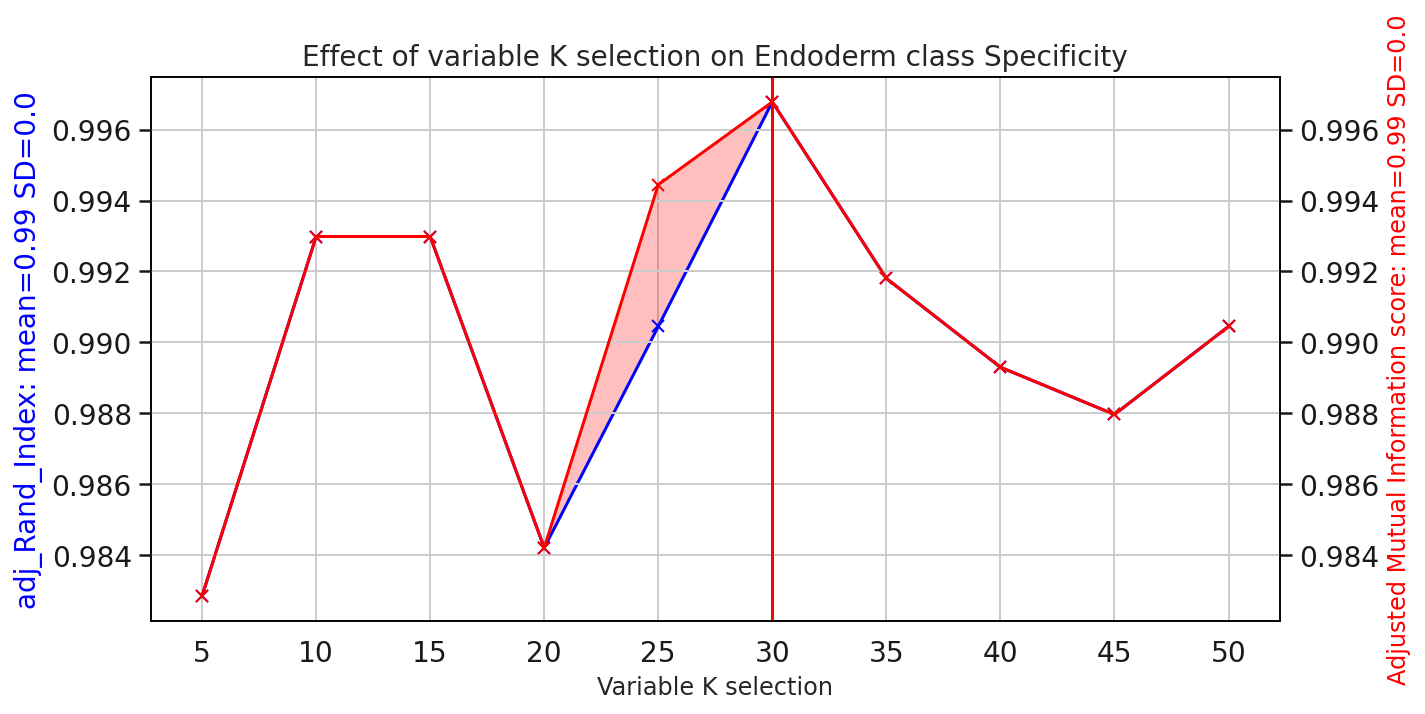

In [94]:
%matplotlib inline
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
import os
import re

# tables = os.listdir()
# tables = [x for x in tables if x.endswith('.csv') and not x.startswith("concatenated")]
# name = "./concatenated_scores_minus_PCs.csv"
# file = pd.read_csv(name)
#file = file.drop([0])

file = Metrics[['MI','ADJ_RAND']]

mean_rand = round(np.mean(file["ADJ_RAND"]),2)
sd_rand = round(np.std(file["ADJ_RAND"]),2)

mean_mi = round(np.mean(file["MI"]),2)
sd_mi = round(np.std(file["MI"]),2)
rand_x = np.array(file.index).astype(float)
rand_y = np.array(file["ADJ_RAND"]).astype(float)
mi_x = np.array(file.index).astype(float)
mi_y= np.array(file["MI"]).astype(float)

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (10,5))
# make a plot
ax.plot(rand_x, rand_y, 'bx-', color="blue")
# set x-axis label
ax.set_xlabel("Variable K selection",fontsize=12)
# set y-axis label
rand_label = "adj_Rand_Index: mean="+str(mean_rand) + " SD=" + str(sd_rand)
ax.set_ylabel(rand_label,color="blue",fontsize=14)
# make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax2.plot(mi_x, mi_y, 'bx-',color="red")
mi_label = "Adjusted Mutual Information score: mean="+str(mean_mi) + " SD=" + str(sd_mi)
ax2.set_ylabel(mi_label,color="red",fontsize=12)
ax.fill_between(mi_x, rand_y, mi_y, where=mi_y >= rand_y,facecolor='red',interpolate=True,alpha=.25)

plt.axvline(x=30, color='red')

plt.title('Effect of variable K selection on Endoderm class Specificity')
plt.savefig("./variable_k_effect_endoderm.pdf",dpi=200)
#Set X ticks to integer values
plt.xticks(np.arange(min(rand_x), (max(rand_x)+1), 5))
plt.show()

In [167]:
len(adata.obs['cell.labels'][(adata.obs['cell.labels'].isin(['Endoderm']))])

1602

<ipython-input-220-9ca3ed37bf0d>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(rand_x, rand_y, 'bx-', color="blue")
<ipython-input-220-9ca3ed37bf0d>:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(mi_x, mi_y, 'bx-',color="red")


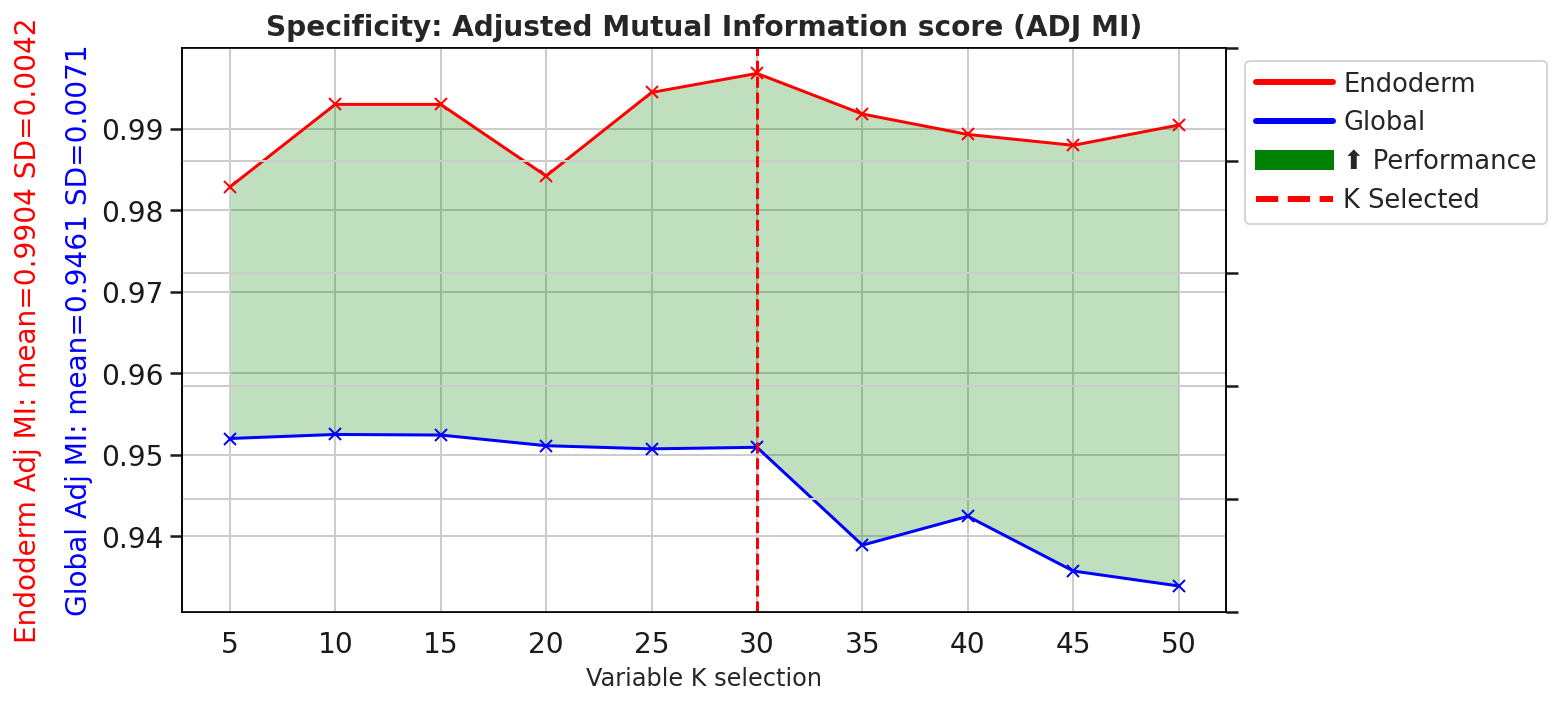

In [220]:
# MI metric vs GLobal
%matplotlib inline
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
import os
import re

# tables = os.listdir()
# tables = [x for x in tables if x.endswith('.csv') and not x.startswith("concatenated")]
# name = "./concatenated_scores_minus_PCs.csv"
# file = pd.read_csv(name)
#file = file.drop([0])

file = Metrics[['MI','global_MI']]

mean_rand = round(np.mean(file["global_MI"]),4)
sd_rand = round(np.std(file["global_MI"]),4)
mean_mi = round(np.mean(file["MI"]),4)
sd_mi = round(np.std(file["MI"]),4)
rand_x = np.array(file.index).astype(float)
rand_y = np.array(file["global_MI"]).astype(float)
mi_x = np.array(file.index).astype(float)
mi_y= np.array(file["MI"]).astype(float)


from matplotlib import rcParams
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
rcParams.update({'figure.autolayout': True})

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (11,5))
# make a plot
ax.plot(rand_x, rand_y, 'bx-', color="blue")
# set x-axis label
ax.set_xlabel("Variable K selection",fontsize=12)
# set y-axis label
rand_label = "Global Adj MI: mean="+str(mean_rand) + " SD=" + str(sd_rand)
ax.set_ylabel(rand_label,color="blue",fontsize=14)
# make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax.plot(mi_x, mi_y, 'bx-',color="red")
mi_label = "Endoderm Adj MI: mean="+str(mean_mi) + " SD=" + str(sd_mi)
ax2.set_ylabel(mi_label,color="red",fontsize=14, labelpad=70)
ax2.yaxis.set_label_position("left")


ax.fill_between(mi_x, rand_y, mi_y, where=mi_y <= rand_y,facecolor='red',interpolate=True,alpha=.25)
ax.fill_between(mi_x, rand_y, mi_y, where=mi_y >= rand_y,facecolor='green',interpolate=True,alpha=.25)
plt.axvline(x=30, color='red', linestyle='dashed')

plt.yticks(color='w')
plt.title('Specificity: Adjusted Mutual Information score (ADJ MI)',fontweight="bold")

# Manual legend
red_patch = Line2D([0], [0], color='red', lw=3, label='Endoderm',linestyle='-')
blue_patch =  Line2D([0], [0], color='blue', lw=3, label='Global',linestyle='-')
green_patch = mpatches.Patch(color='green', label='⬆ Performance')
red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
plt.legend(handles=[red_patch, blue_patch,green_patch,red_line],bbox_to_anchor=(1.32, 1), handlelength=3)

#Set X ticks to integer values
plt.xticks(np.arange(min(rand_x), (max(rand_x)+1), 5))

plt.savefig("./MI_variable_k_effect_endoderm.pdf",dpi=200,bbox_inches = 'tight')
# plt.yticks(np.arange(min(rand_x), (max(rand_x)+1), 0.1))

<ipython-input-219-5dda26895b5f>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(rand_x, rand_y, 'bx-', color="blue")
<ipython-input-219-5dda26895b5f>:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(mi_x, mi_y, 'bx-',color="red")


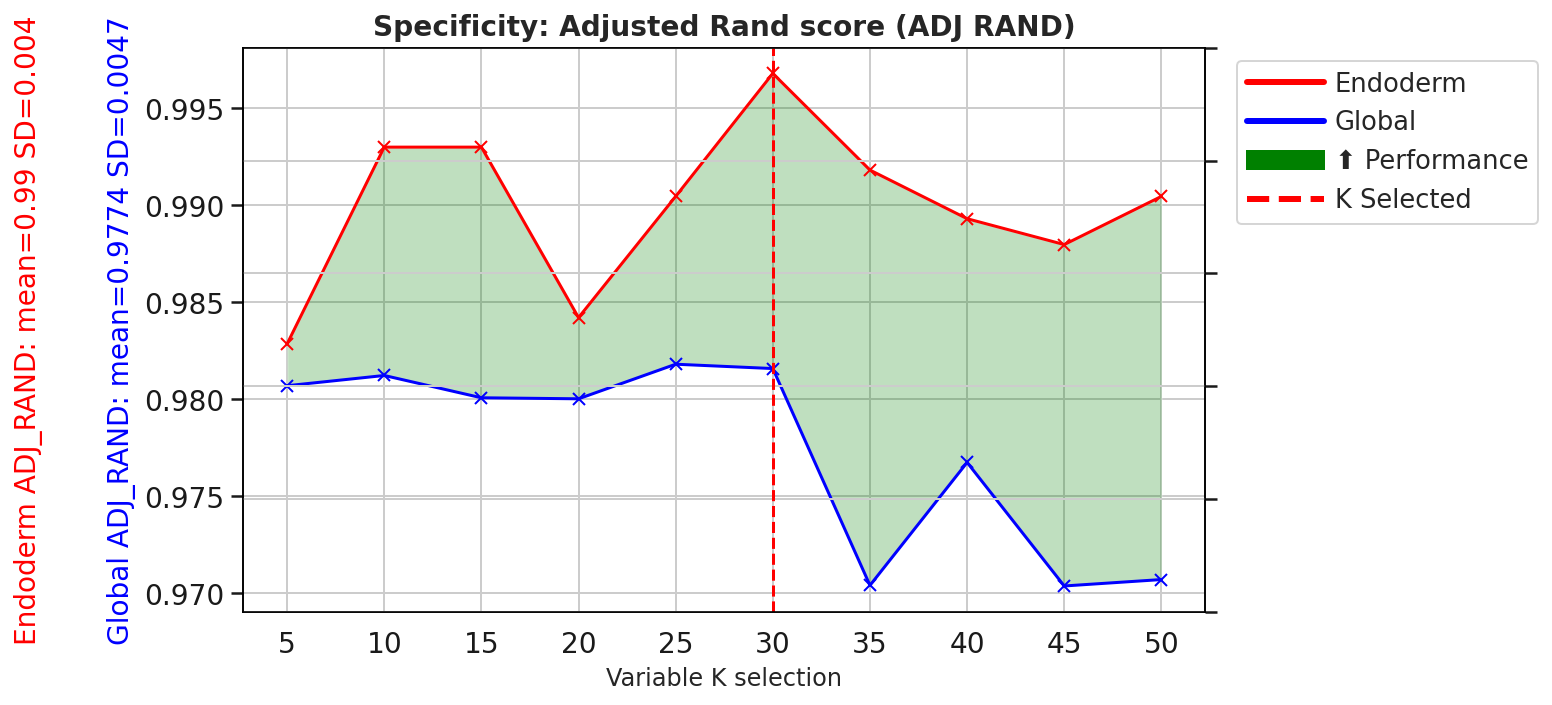

In [219]:
# MI metric vs GLobal
%matplotlib inline
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
import os
import re

# tables = os.listdir()
# tables = [x for x in tables if x.endswith('.csv') and not x.startswith("concatenated")]
# name = "./concatenated_scores_minus_PCs.csv"
# file = pd.read_csv(name)
#file = file.drop([0])

file = Metrics[['ADJ_RAND','global_ADJ_RAND']]

mean_rand = round(np.mean(file["global_ADJ_RAND"]),4)
sd_rand = round(np.std(file["global_ADJ_RAND"]),4)

mean_mi = round(np.mean(file["ADJ_RAND"]),4)
sd_mi = round(np.std(file["ADJ_RAND"]),4)
rand_x = np.array(file.index).astype(float)
rand_y = np.array(file["global_ADJ_RAND"]).astype(float)
mi_x = np.array(file.index).astype(float)
mi_y= np.array(file["ADJ_RAND"]).astype(float)


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (11,5))
# make a plot
ax.plot(rand_x, rand_y, 'bx-', color="blue")
# set x-axis label
ax.set_xlabel("Variable K selection",fontsize=12)
# set y-axis label
rand_label = "Global ADJ_RAND: mean="+str(mean_rand) + " SD=" + str(sd_rand)
ax.set_ylabel(rand_label,color="blue",fontsize=14)
# make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax.plot(mi_x, mi_y, 'bx-',color="red")
mi_label = "Endoderm ADJ_RAND: mean="+str(mean_mi) + " SD=" + str(sd_mi)
ax2.set_ylabel(mi_label,color="red",fontsize=14, labelpad=100)
ax2.yaxis.set_label_position("left")

ax.fill_between(mi_x, rand_y, mi_y, where=mi_y <= rand_y,facecolor='red',interpolate=True,alpha=.25)
ax.fill_between(mi_x, rand_y, mi_y, where=mi_y >= rand_y,facecolor='green',interpolate=True,alpha=.25)
plt.axvline(x=30, color='red', linestyle='dashed')

plt.yticks(color='w')

plt.title('Specificity: Adjusted Rand score (ADJ RAND)',fontweight="bold")
# Manual legend
red_patch = Line2D([0], [0], color='red', lw=3, label='Endoderm',linestyle='-')
blue_patch =  Line2D([0], [0], color='blue', lw=3, label='Global',linestyle='-')
green_patch = mpatches.Patch(color='green', label='⬆ Performance')
red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
plt.legend(handles=[red_patch, blue_patch,green_patch,red_line],bbox_to_anchor=(1.36, 1), handlelength=3)
#Set X ticks to integer values
plt.xticks(np.arange(min(rand_x), (max(rand_x)+1), 5))

plt.savefig("./RAND_variable_k_effect_endoderm.pdf",dpi=200,bbox_inches = 'tight')

# Homogeniety

In [97]:
['SI','Global_SI','WSS','Global_WSS','MI','global_MI','ADJ_RAND','global_ADJ_RAND','Cluster_size']

['SI',
 'Global_SI',
 'WSS',
 'Global_WSS',
 'MI',
 'global_MI',
 'ADJ_RAND',
 'global_ADJ_RAND',
 'Cluster_size']

In [98]:
np.array(mi_y)

array([0.98284613, 0.99298518, 0.99298518, 0.98420262, 0.9904473 ,
       0.99678259, 0.99180372, 0.98929761, 0.9879639 , 0.9904473 ])

<ipython-input-218-abebc755d103>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(rand_x, rand_y, 'bx-', color="blue")
<ipython-input-218-abebc755d103>:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(mi_x, mi_y, 'bx-',color="red")


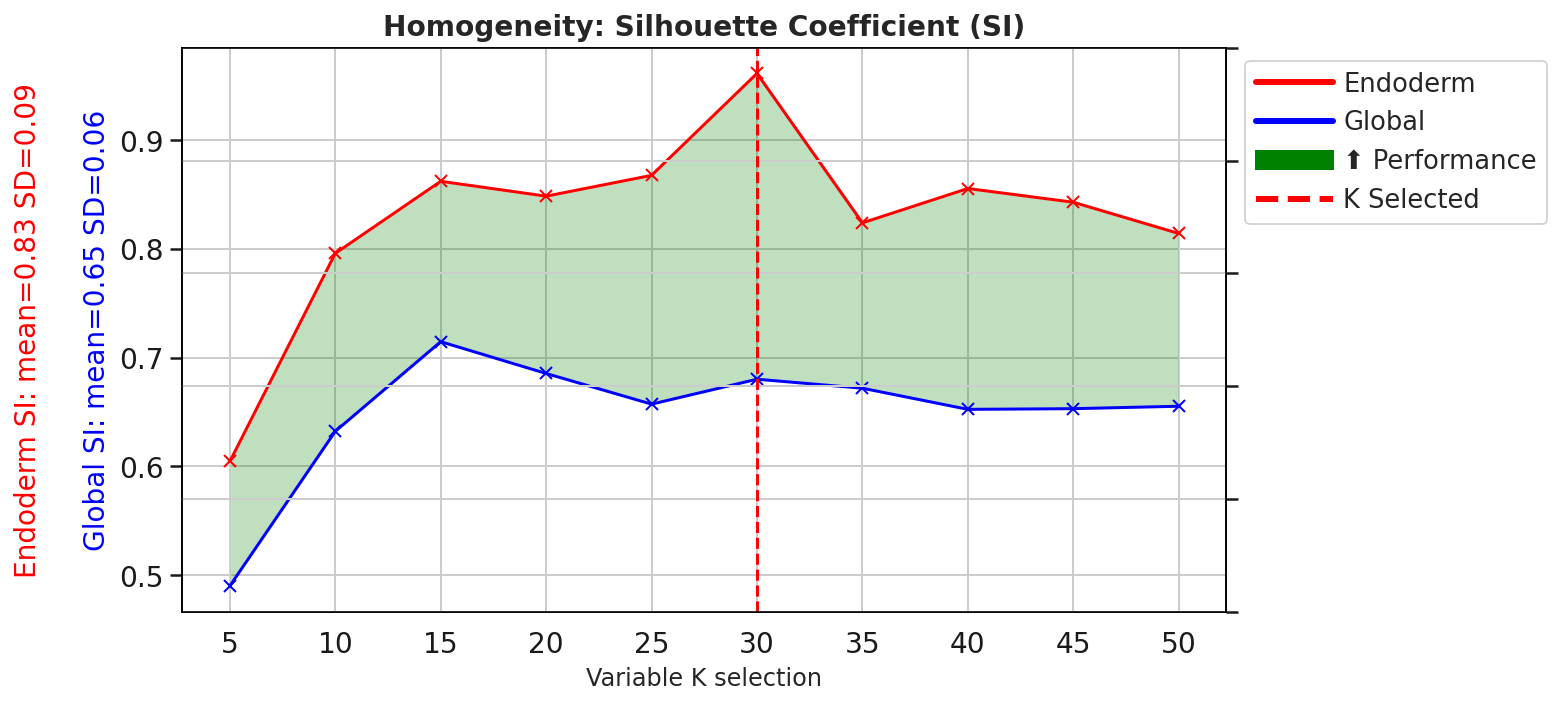

In [218]:
# MI metric vs GLobal
%matplotlib inline
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
import os
import re

# tables = os.listdir()
# tables = [x for x in tables if x.endswith('.csv') and not x.startswith("concatenated")]
# name = "./concatenated_scores_minus_PCs.csv"
# file = pd.read_csv(name)
#file = file.drop([0])

file = Metrics[['SI','Global_SI']]

mean_rand = round(np.mean(file["Global_SI"]),2)
sd_rand = round(np.std(file["Global_SI"]),2)

mean_mi = round(np.mean(file["SI"]),2)
sd_mi = round(np.std(file["SI"]),2)
rand_x = np.array(file.index).astype(float)
rand_y = np.array(file["Global_SI"]).astype(float)
mi_x = np.array(file.index).astype(float)
mi_y= np.array(file["SI"]).astype(float)


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (11,5))
# make a plot
ax.plot(rand_x, rand_y, 'bx-', color="blue")
# set x-axis label
ax.set_xlabel("Variable K selection",fontsize=12)
# set y-axis label
rand_label = "Global SI: mean="+str(mean_rand) + " SD=" + str(sd_rand)
ax.set_ylabel(rand_label,color="blue",fontsize=14)
# make a plot with different y-axis using second axis object

# Fill between
ax.plot(mi_x, mi_y, 'bx-',color="red")
ax.fill_between(mi_x, rand_y, mi_y, where=mi_y <= rand_y,facecolor='red',interpolate=True,alpha=.25)
ax.fill_between(mi_x, rand_y, mi_y, where=mi_y >= rand_y,facecolor='green',interpolate=True,alpha=.25)
# ax.fill_between(mi_x, y1, mi_y, where=y2 <= y1, facecolor='red', interpolate=True)

ax2=ax.twinx()


mi_label = "Endoderm SI: mean="+str(mean_mi) + " SD=" + str(sd_mi)
ax2.set_ylabel(mi_label,color="red",fontsize=14, labelpad=70)
ax2.yaxis.set_label_position("left")

plt.axvline(x=30, color='red', linestyle='dashed')
plt.yticks(color='w')
# Manual legend
red_patch = Line2D([0], [0], color='red', lw=3, label='Endoderm',linestyle='-')
blue_patch =  Line2D([0], [0], color='blue', lw=3, label='Global',linestyle='-')
green_patch = mpatches.Patch(color='green', label='⬆ Performance')
red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
plt.legend(handles=[red_patch, blue_patch,green_patch,red_line],bbox_to_anchor=(1.32, 1), handlelength=3)
#Set X ticks to integer values
plt.xticks(np.arange(min(rand_x), (max(rand_x)+1), 5))


plt.title('Homogeneity: Silhouette Coefficient (SI)',fontweight="bold")
plt.savefig("./SI_variable_k_effect_endoderm.pdf",dpi=200,bbox_inches = 'tight')

<ipython-input-217-7c63c7e7a0ae>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(rand_x, rand_y, 'bx-', color="blue")
<ipython-input-217-7c63c7e7a0ae>:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(mi_x, mi_y, 'bx-',color="red")


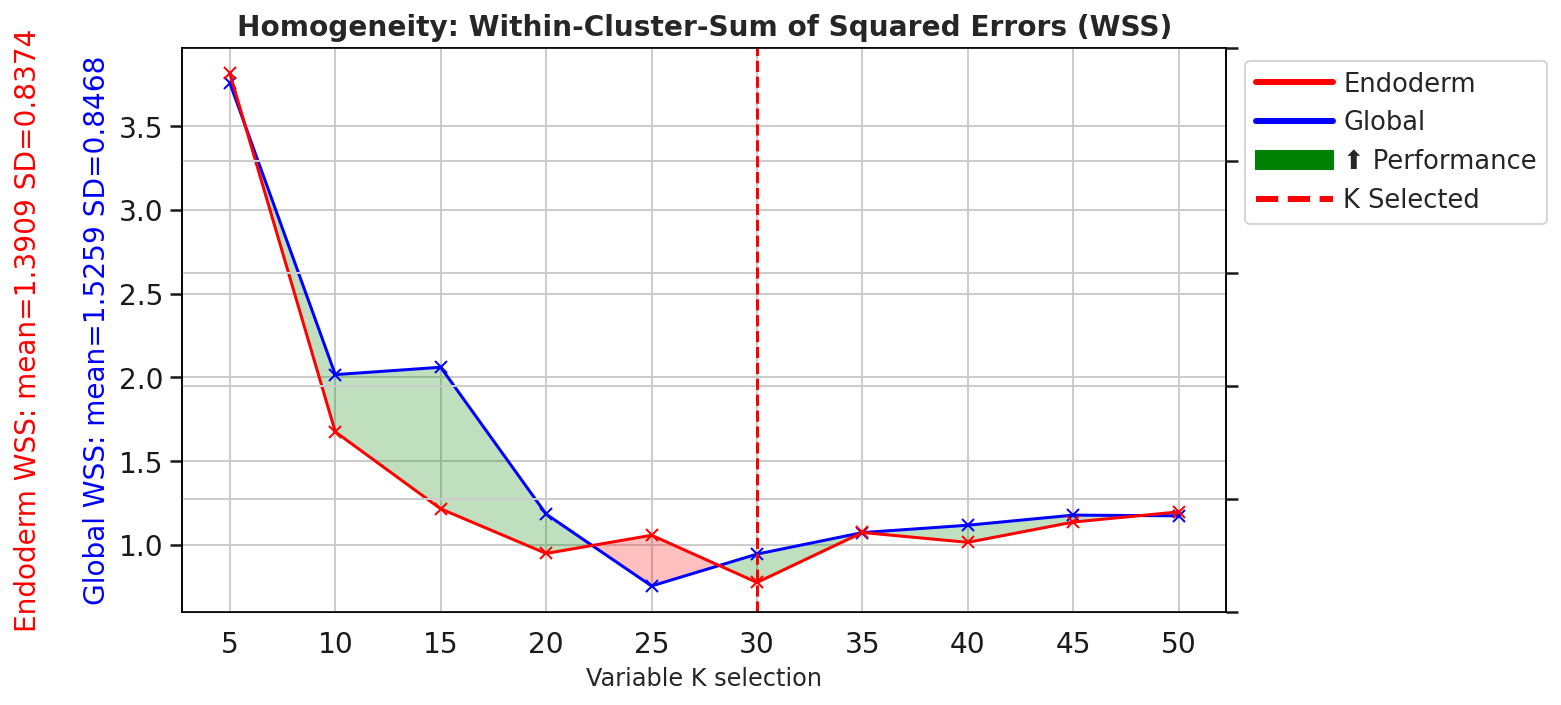

In [217]:
# MI metric vs GLobal
%matplotlib inline
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
import os
import re

# tables = os.listdir()
# tables = [x for x in tables if x.endswith('.csv') and not x.startswith("concatenated")]
# name = "./concatenated_scores_minus_PCs.csv"
# file = pd.read_csv(name)
#file = file.drop([0])

file = Metrics[['WSS','Global_WSS']]

mean_rand = round(np.mean(file["Global_WSS"]),4)
sd_rand = round(np.std(file["Global_WSS"]),4)

mean_mi = round(np.mean(file["WSS"]),4)
sd_mi = round(np.std(file["WSS"]),4)
rand_x = np.array(file.index).astype(float)
rand_y = np.array(file["Global_WSS"]).astype(float)
mi_x = np.array(file.index).astype(float)
mi_y= np.array(file["WSS"]).astype(float)


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (11,5))
# make a plot
ax.plot(rand_x, rand_y, 'bx-', color="blue")
# set x-axis label
ax.set_xlabel("Variable K selection",fontsize=12)
# set y-axis label
rand_label = "Global WSS: mean="+str(mean_rand) + " SD=" + str(sd_rand)
ax.set_ylabel(rand_label,color="blue",fontsize=14)
# make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax.plot(mi_x, mi_y, 'bx-',color="red")
mi_label = "Endoderm WSS: mean="+str(mean_mi) + " SD=" + str(sd_mi)
ax2.set_ylabel(mi_label,color="red",fontsize=14, labelpad=70)
ax2.yaxis.set_label_position("left")

plt.axvline(x=30, color='red', linestyle='dashed')
ax.fill_between(mi_x, rand_y, mi_y, where=mi_y >= rand_y,facecolor='red',interpolate=True,alpha=.25)
ax.fill_between(mi_x, rand_y, mi_y, where=mi_y <= rand_y,facecolor='green',interpolate=True,alpha=.25)
plt.yticks(color='w')

plt.title('Homogeneity: Within-Cluster-Sum of Squared Errors (WSS)',fontweight="bold")

# Manual legend
red_patch = Line2D([0], [0], color='red', lw=3, label='Endoderm',linestyle='-')
blue_patch =  Line2D([0], [0], color='blue', lw=3, label='Global',linestyle='-')
green_patch = mpatches.Patch(color='green', label='⬆ Performance')
red_line = Line2D([0], [0], color='red', lw=3, label='K Selected',linestyle='--')
plt.legend(handles=[red_patch, blue_patch,green_patch,red_line],bbox_to_anchor=(1.32, 1), handlelength=3)
#Set X ticks to integer values
plt.xticks(np.arange(min(rand_x), (max(rand_x)+1), 5))

plt.savefig("./WSS_variable_k_effect_endoderm.pdf",dpi=200)

<ipython-input-104-7763c3613abd>:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(rand_x, rand_y, 'bx-', color="blue")
<ipython-input-104-7763c3613abd>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(mi_x, mi_y, 'bx-',color="red")


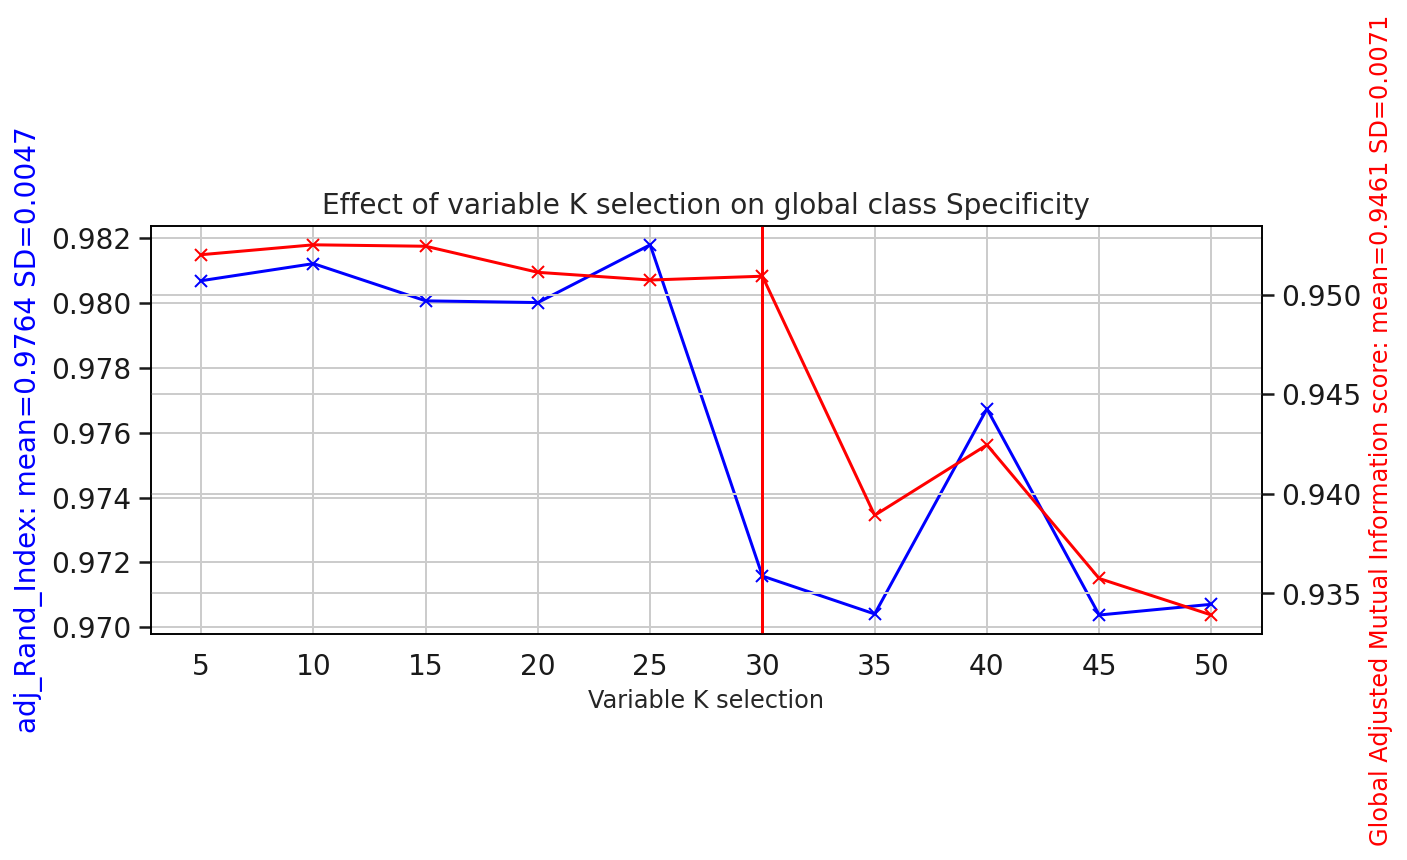

In [104]:
%matplotlib inline
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
import os
import re

# tables = os.listdir()
# tables = [x for x in tables if x.endswith('.csv') and not x.startswith("concatenated")]
# name = "./concatenated_scores_minus_PCs.csv"
# file = pd.read_csv(name)
#file = file.drop([0])

file = Metrics[['global_MI','global_ADJ_RAND']]

mean_rand = round(np.mean(file["global_ADJ_RAND"]),4)
sd_rand = round(np.std(file["global_ADJ_RAND"]),4)

mean_mi = round(np.mean(file["global_MI"]),4)
sd_mi = round(np.std(file["global_MI"]),4)
rand_x = file.index
rand_y = file["global_ADJ_RAND"]
mi_x = file.index
mi_y= file["global_MI"]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (10,5))
# make a plot
ax.plot(rand_x, rand_y, 'bx-', color="blue")
# set x-axis label
ax.set_xlabel("Variable K selection",fontsize=12)
# set y-axis label
rand_label = "adj_Rand_Index: mean="+str(mean_rand) + " SD=" + str(sd_rand)
ax.set_ylabel(rand_label,color="blue",fontsize=14)
# make a plot with different y-axis using second axis object
ax2=ax.twinx()
ax2.plot(mi_x, mi_y, 'bx-',color="red")
mi_label = "Global Adjusted Mutual Information score: mean="+str(mean_mi) + " SD=" + str(sd_mi)
ax2.set_ylabel(mi_label,color="red",fontsize=12)

plt.axvline(x=30, color='red')
plt.title('Effect of variable K selection on global class Specificity')
plt.savefig("./variable_k_global_effect.pdf",dpi=200)
#Set X ticks to integer values
plt.xticks(np.arange(min(rand_x), (max(rand_x)+1), 5))
plt.show();